In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, GeometryCollection, box
from shapely.ops import split
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.affinity import scale
from tqdm.auto import tqdm
pd.set_option('display.max_columns', None)

In [2]:
imd = gpd.read_file("input/IMD2018.zip")
df = imd.cx[1747618.6612:1768514.9720,5909569.6924:5922316.0159]
df = df[df.dhb2015_na == "Auckland"].copy()
df.set_index("DZ2018", inplace=True)
df.sample(1)

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7601174,630,4,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,155,1,908.5,2,166,1,1394,3,1981,4,544,1,366,1,2690,5,110,1,217,1,178,1,98,1,223,1,205,1,184,1,"POLYGON ((1760610.906 5917545.088, 1760734.044..."


<Axes: >

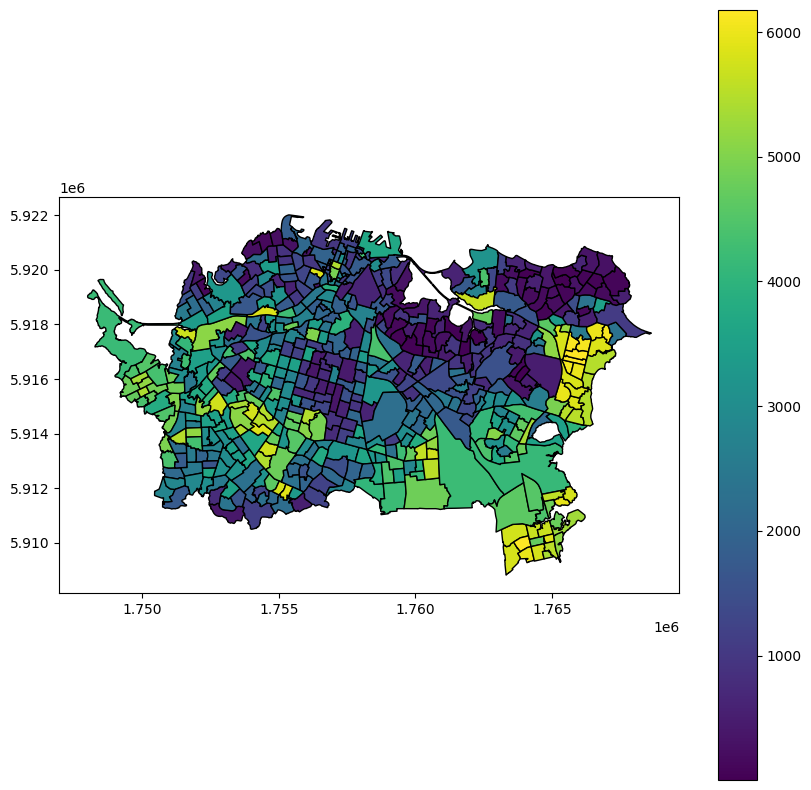

In [3]:
df.plot("Rank_IMD18", legend=True, figsize=(10,10), edgecolor="black")

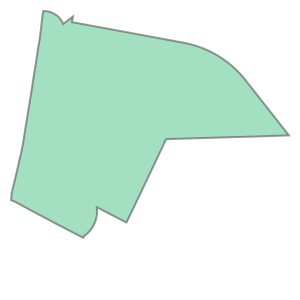

In [4]:
# Pick the most central polygon
df_centroid = box(*df.total_bounds).centroid
start_index = df.distance(df_centroid).idxmin()
start = df.geometry[start_index]
start

In [5]:
df.centroid.distance(df.boundary).describe()

count    581.000000
mean     148.937563
std       69.089545
min       10.112110
25%      110.898948
50%      146.221736
75%      180.194046
max      679.568032
dtype: float64

In [6]:
radius = df.centroid.distance(df.boundary).mean()
radius

148.93756349772616

A hexagon is made of 6 equilateral triangles, with internal angles of 120 degrees. The internal angles of the equilateral triangles are all 60 degrees.

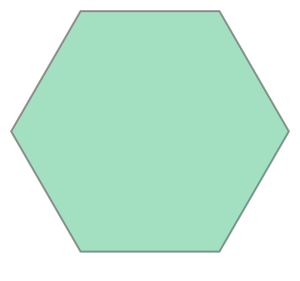

In [7]:
def create_hexagon(center, radius, rotate=False):
    """Create a hexagon centered at 'center' with a given 'radius', and include lines connecting each vertex to the center."""
    vertices = []
    for i in range(6):
        angle = math.radians(60 * i)  # Convert angle to radians
        if rotate:
            angle += math.radians(30)
        x = center.x + radius * math.cos(angle)  # X-coordinate
        y = center.y + radius * math.sin(angle)  # Y-coordinate
        vertices.append((x, y))  # Append vertex coordinates
    hexagon = Polygon(vertices)  # Create a polygon from the vertices
    return hexagon

start_hexagon = create_hexagon(start.centroid, radius)
assert start_hexagon.is_valid
start_hexagon

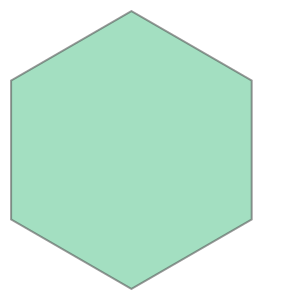

In [8]:
create_hexagon(start.centroid, radius, True)

Some options here for splitting up a hexagon to represent variables within. Here's the composite equilateral triangles:

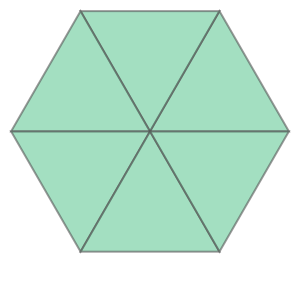

In [9]:
def hexagon_to_triangles(hexagon):
    center = hexagon.centroid
    vertices = list(hexagon.exterior.coords)
    triangles = []
    for i in range(6):
        next_i = (i + 1) % 6  # Wrap around to form a closed shape
        triangle = Polygon([center, vertices[i], vertices[next_i]])
        triangles.append(triangle)
    return GeometryCollection(triangles)

triangles = hexagon_to_triangles(start_hexagon)
assert triangles.is_valid
triangles

Evenly sliced along the vertical axis (y)

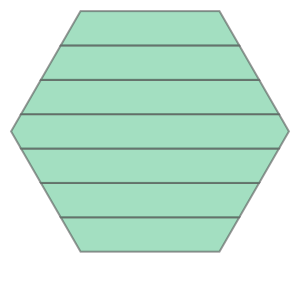

In [10]:
def slice_hexagon(hexagon, slices = 7):
  if hexagon is None:
    return None
  minx, miny, maxx, maxy = hexagon.bounds
  poly = hexagon
  segments = []
  slice_height = (maxy-miny) / slices
  for i in range(1, slices + 1):
    y = miny + slice_height * i
    parts = list(split(poly, LineString([(minx, y), (maxx, y)])).geoms)
    parts.sort(key=lambda p: p.bounds[1], reverse=True)
    #print(i, len(parts), [p.bounds[1] for p in parts], [p.area for p in parts])
    if len(parts) == 2:
      segments.append(parts[1])
      poly = parts[0]
    if i == slices:
      segments.append(parts[0])
  return GeometryCollection(segments)

slice_hexagon(start_hexagon)

Sub hexagons, with a nice star in the middle

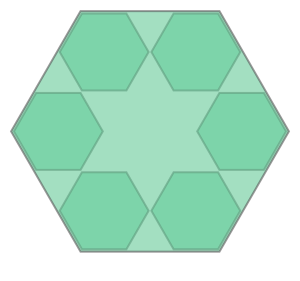

In [11]:
def sub_hexagons(hexagon):
    center = hexagon.centroid
    hexagons = []
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .66 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .66 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .32))
    return GeometryCollection(hexagons)

GeometryCollection(list(sub_hexagons(start_hexagon).geoms) + [start_hexagon])

Better internal tesselation with rotated internal hexagons

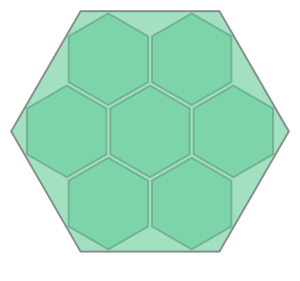

In [12]:
def sub_hexagons(hexagon):
    if hexagon is None:
        return None
    center = hexagon.centroid
    radius = start_hexagon.length / 6
    hexagons = [create_hexagon(center, radius * .33, True)]
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .6 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .6 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .33, True))
    return GeometryCollection(hexagons)

sub = sub_hexagons(start_hexagon)
GeometryCollection(list(sub.geoms) + [start_hexagon])

<Axes: >

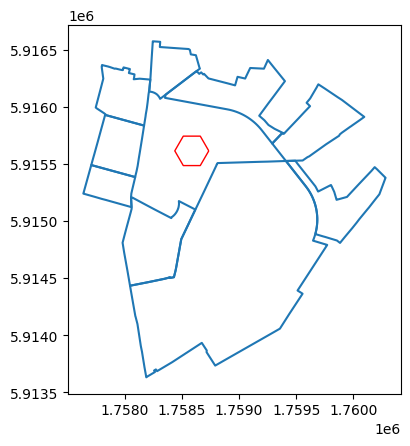

In [13]:
neighbours = df.geometry[df.touches(start)]
ax = neighbours.boundary.plot()
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

An equilateral triangle, split into two, makes two equal area triangles. The length of the line splitting the triangle, * 2, is the distance to the center of the neighbouring tesselated hexagon

128.98371356700807


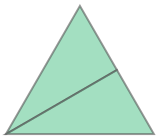

In [14]:
triangle = triangles.geoms[0]
v1, v2, v3 = set(triangle.exterior.coords)
midpoint = ((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
# Create a line from the midpoint to the opposite vertex
split_line = LineString([midpoint, v3])
print(split_line.length)
split_triangles = split(triangle, scale(split_line, yfact=1.001))
split_triangles

In [15]:
radius, split_line.length * 2

(148.93756349772616, 257.96742713401613)

Create the neighbouring 6 tesselating hexagons

<Axes: >

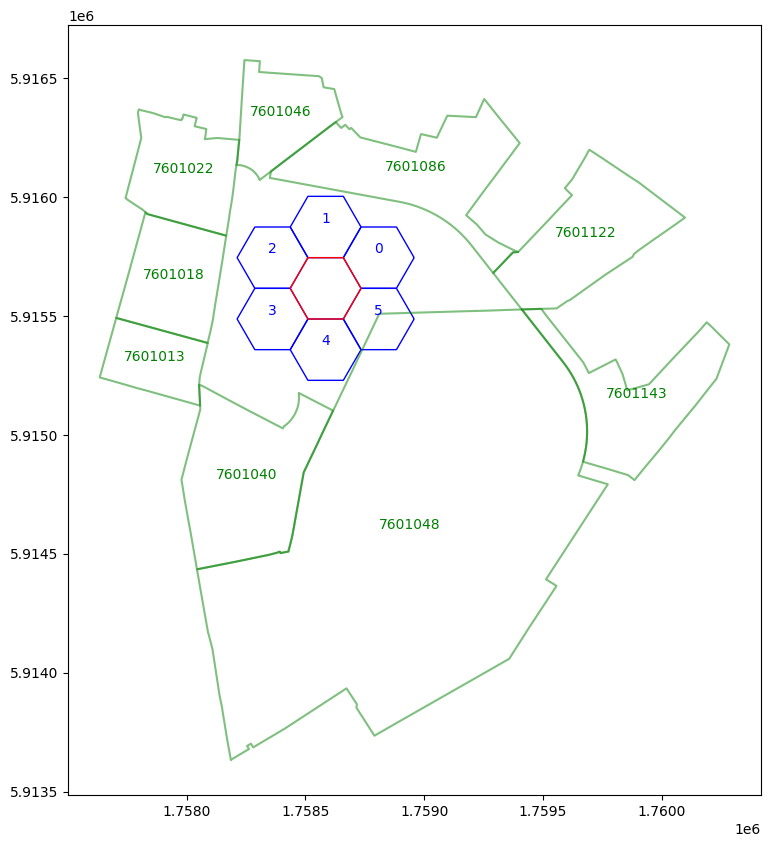

In [16]:
from shapely.geometry import Point
hex_neighbours = []
for i in range(6):
    angle = math.radians(60 * i + 30)  # Convert angle to radians
    x = start.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
    y = start.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
    hex_neighbours.append(create_hexagon(Point([x, y]), radius))

hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
ax = hex_neighbours.plot(edgecolor="blue", facecolor="none", figsize=(10,10))
for i in range(6):
  p = hex_neighbours.centroid.iloc[i]
  ax.annotate(text=str(i), xy=[p.x, p.y + radius / 8], ha='center', color="blue")
neighbours.boundary.plot(ax=ax, color="green", alpha=.5)
for i in neighbours.index:
  ax.annotate(text=str(i), xy=[neighbours.centroid[i].x, neighbours.centroid[i].y], ha='center', color="green")
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

                   0            1            2            3            4  \
DZ2018                                                                     
7601013  1037.278352   913.320417   658.989063   525.519917   719.696727   
7601018   866.270091   674.339088   424.246421   448.249385   704.711413   
7601022   894.379258   638.797863   515.889404   718.381927   952.850534   
7601040  1083.400267  1109.612078   935.835365   680.333649   636.687560   
7601046   722.536931   501.793548   595.691331   853.324329   999.212321   
7601048  1148.808284  1318.769759  1279.153864  1055.425191   833.384142   
7601086   396.314379   445.256259   703.120971   865.630991   841.503989   
7601122   875.427342  1095.127849  1320.731186  1362.506789  1193.102165   
7601143  1236.926378  1494.826013  1643.323584  1569.076814  1325.701362   

                   5  
DZ2018                
7601013   958.045394  
7601018   878.274647  
7601022  1024.619428  
7601040   872.251215  
7601046   946.241970  
76

<Axes: ylabel='DZ2018'>

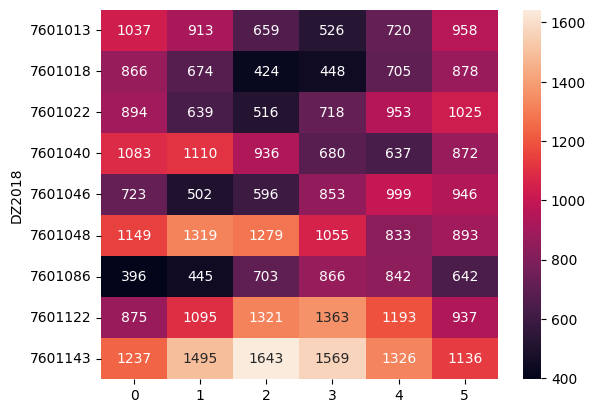

In [17]:
# Build a cost distance matrix
distance_matrix = neighbours.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
print(distance_matrix)
sns.heatmap(distance_matrix.round(), annot=True, fmt=".0f")

  0%|          | 0/574 [00:00<?, ?it/s]

Assigned hexagons for 581 out of 581 DZs


<Axes: >

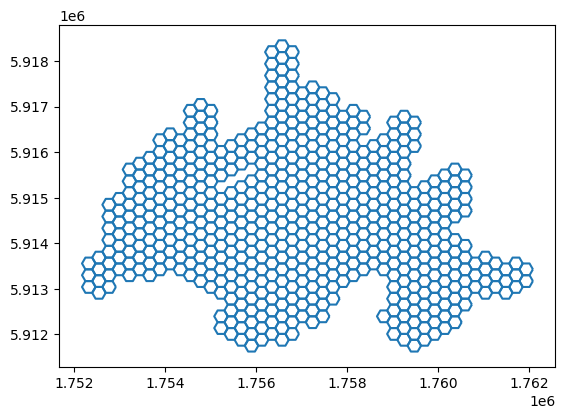

In [18]:
# Create a new hex_geo column to store best matching hexagons for each DZ
df["hex_geo"] = gpd.GeoSeries()
df.loc[start_index, "hex_geo"] = start_hexagon

# Find the optimal hexagons for each DZ, based on the distance matrix
row_ind, col_ind = linear_sum_assignment(distance_matrix)
distance_matrix.index[row_ind], hex_neighbours[col_ind]
df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

pbar = tqdm(total=sum(df.hex_geo.isna()))

hexagons_to_use = []

def assign_neighbours(neighbour_index):
   global hexagons_to_use
   # Recursive function, takes an index and assigns hexagons to its neighbours
   geometry = df.geometry[neighbour_index]
   neighbours = df.geometry[df.touches(geometry)]
   neighbours_to_process = set()
   for neighbour_index in neighbours.index:
      neighbour = neighbours[neighbour_index]
      neighbour_hex = df.hex_geo[neighbour_index]
      if not neighbour_hex:
          #print(f"{neighbour_index} is missing hex_geo")
          continue
      nn = df.geometry[df.hex_geo.isna() & df.touches(neighbour)]
      if len(nn) == 0:
         # No neighbours
         continue
      hex_neighbours = []
      for i in range(6):
            angle = math.radians(60 * i + 30)  # Convert angle to radians
            x = neighbour_hex.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
            y = neighbour_hex.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
            hex = create_hexagon(Point([x, y]), radius)
            # Filter out already used hexagons
            if df.hex_geo.centroid.distance(hex.centroid).min() > 1:
               hex_neighbours.append(hex)
      for hex in hexagons_to_use:
         if df.hex_geo.centroid.distance(hex.centroid).min() > 1 and hex not in hex_neighbours:
               hex_neighbours.append(hex)

      if len(hex_neighbours) == 0:
         # No available hexagons
         #print(f"No available hexagons for {neighbour_index}")
         continue
      hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
      neighbours_to_process.update(nn.index)
      # Build a cost distance matrix
      distance_matrix = nn.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
      if len(hexagons_to_use):
          # Discount for using leftovers
          for hex in hexagons_to_use:
              minidx = hex_neighbours.centroid.distance(hex).idxmin()
              dist = hex_neighbours.centroid[minidx].distance(hex)
              if dist < 1:
                  distance_matrix[minidx] /= 10
          hexagons_to_use = []
      row_ind, col_ind = linear_sum_assignment(distance_matrix)
      if len(col_ind) < len(hex_neighbours):
          # Store unused hexagons, such that they might be used in the next call
          hexagons_to_use.extend(hex_neighbours[~hex_neighbours.index.isin(col_ind)].tolist())
      # Assign the optimal hexagons to each neighbour
      df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values
      pbar.update(len(col_ind))
      for neighbour in neighbours_to_process:
         assign_neighbours(neighbour)

assign_neighbours(start_index)
pbar.close()
print(f"Assigned hexagons for {sum(~df.hex_geo.isna())} out of {len(df)} DZs")
df.hex_geo.boundary.plot()

In [19]:
rank_cols = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi', 'Rank_Healt', 'Rank_Educa', 'Rank_Acces']

In [20]:
df["sliced_hexagons"] = df.hex_geo.apply(slice_hexagon)
df["sub_hexagons"] = df.hex_geo.apply(sub_hexagons)

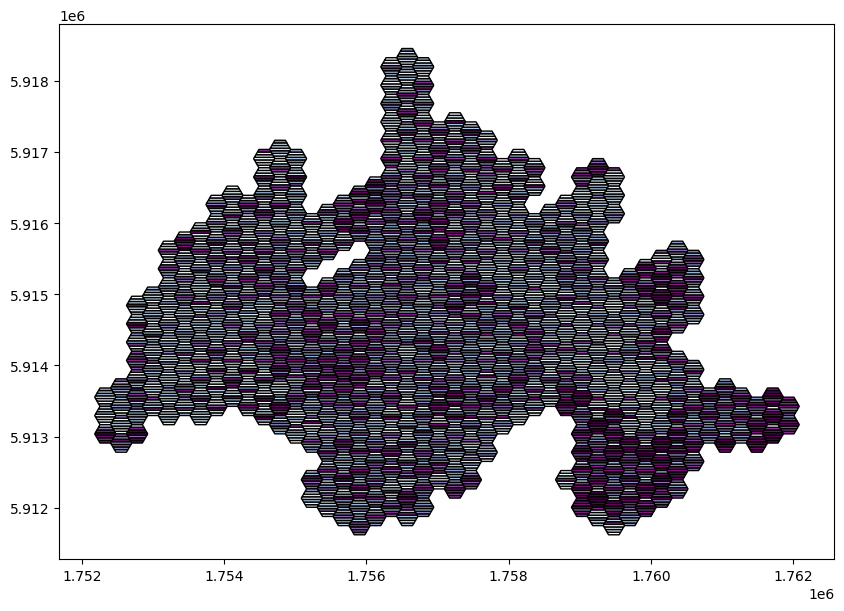

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sliced_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

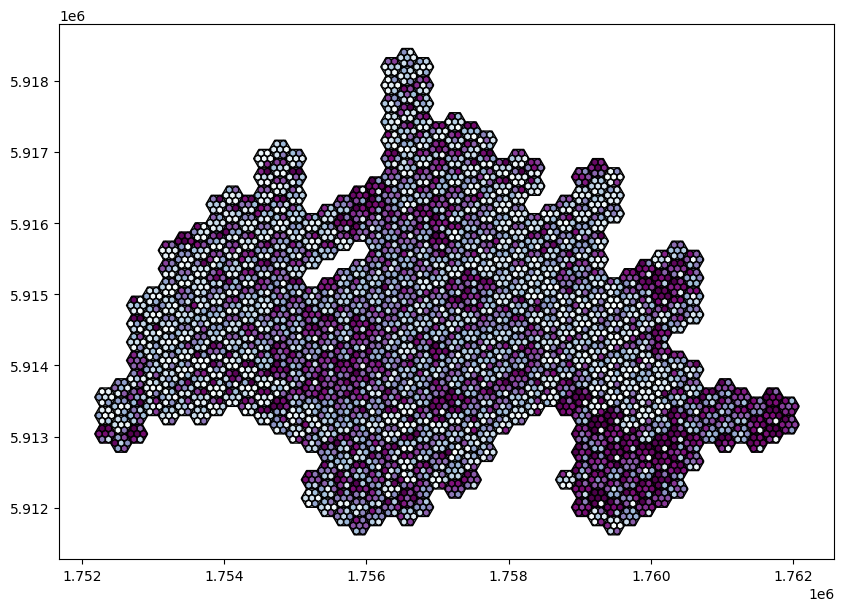

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

df.set_geometry(df.hex_geo).plot("Rank_IMD18", ax=ax, cmap="BuPu", edgecolor="black")
for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sub_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

In [23]:
df.set_geometry(df.hex_geo).explore()